In [1]:
%run IDM_helper_functions.ipynb

## Train IDM

In [2]:
from pyddm import Model
from pyddm.models import DriftConstant, DriftLinear, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model

from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossBIC, LossLikelihood, LossRobustLikelihood,LossSquaredError
from pyddm.functions import fit_adjust_model

## Simulate from OUM and fit with OUM

In [8]:
n_trials = 1000
sim_num = 20

prior = utils.BoxUniform(low=[0, 0.5, -4, 0.2], high=[2, 2, 4, 0.5])
OUM_parameters = prior.sample((20,))

par_fitted = np.zeros((sim_num,4))

In [9]:
for i in range(sim_num):
    print(i)
    model = Model(name='Simple model',
                  drift=DriftLinear(drift=OUM_parameters[i,0], 
                                    t = 0, 
                                    x = OUM_parameters[i,2]),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=OUM_parameters[i,1]),
                  overlay=OverlayNonDecision(nondectime=OUM_parameters[i,3]),
                  dx=.008, dt=.005, T_dur=2) # also change the lower part
    #display_model(model)
    sol = model.solve()

    samp = sol.resample(n_trials)

    model_fit = Model(name='Simple model (fitted)',
                      drift=DriftLinear(drift=Fittable(minval=0, maxval=2),
                                        t = 0,
                                        x=Fittable(minval=-4, maxval=4)),
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=Fittable(minval=0.5, maxval=2)),
                      overlay=OverlayNonDecision(nondectime=Fittable(minval=0.2, maxval=0.5)),
                      dx=.008, dt=.005, T_dur=2)
                      #dx=.001, dt=.001, T_dur=3)

    fit_adjust_model(samp, model_fit,
                     fitting_method="differential_evolution",
                     lossfunction=LossRobustBIC, verbose=False)
    
    par_fitted[i,0] = np.array(model_fit.parameters()['drift']['drift'])
    par_fitted[i,1] = np.array(model_fit.parameters()['bound']['B'])
    par_fitted[i,2] = np.array(model_fit.parameters()['drift']['x'])
    par_fitted[i,3] = np.array(model_fit.parameters()['overlay']['nondectime'])
    
    print(LCA_parameters[i,:])
    print(par_fitted[i,:])



0


Info: Params [ 2.         -0.05884183  1.93066229  0.24043931] gave 678.0919146192556


NameError: name 'LCA_parameters' is not defined

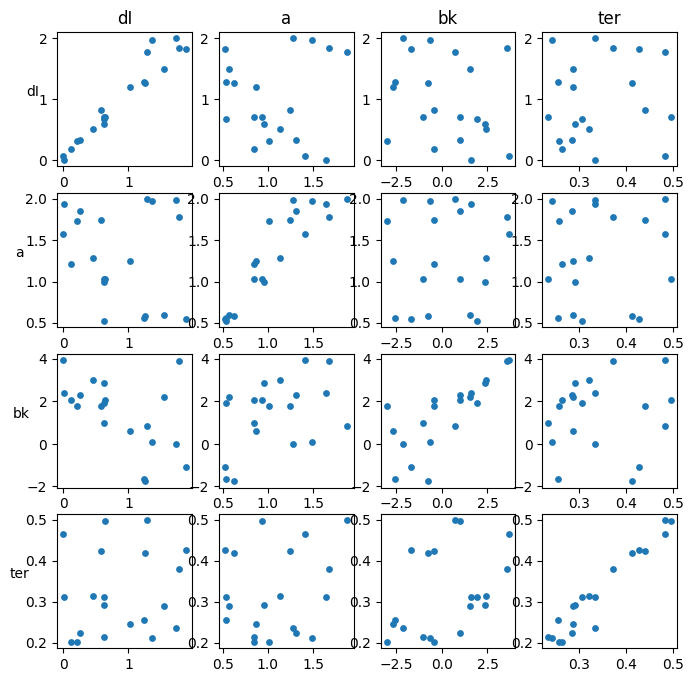

In [29]:
# DE LossRobustLikelihood
#prior = utils.BoxUniform(low=[0, 0.6, -0.4, 0.2], high=[1, 1.5, 0, 0.5])

par_labels = ["dI","a", "bk","ter"]
par_fitted_labels = ["dI","a", "bk","ter"]
sim_fit_plot_all(LCA_parameters[:,:], par_fitted[:,:], par_labels, par_fitted_labels, 
                 s = 15, figsize=(8,8))

In [ ]:
## Simulate from IDM and fit with LCA

In [10]:
n_trials = 100
sim_num = 1

prior_IDM = utils.BoxUniform(low=[0,0.2,0.2,52000, 8200], high=[0.2,0.6,0.5,53000, 8600])
param_IDM = prior_IDM.sample((sim_num,))

par_fitted = np.zeros((sim_num,4))

In [11]:
for i in range(sim_num):
    print(i)
    IDM_o = simul_IDM_EM6(np.tile(param_IDM[i,:], (n_trials,1))) # simulate IDM data
    print(param_IDM[i,:])
    print(IDM_o[0:10,:])
    
    # rescale data
    IDM_o[:,1] = -IDM_o[:,1] + 1 
    IDM_o = np.array(IDM_o[:,:])
    samp = Sample.from_numpy_array(IDM_o, column_names = [])
    
    
    
    model_fit = Model(name='Simple model (fitted)',
                      drift=DriftLinear(drift=Fittable(minval=0, maxval=2),
                                        t = 0,
                                        x=Fittable(minval=-30, maxval=30)),
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=Fittable(minval=0.5, maxval=2)),
                      overlay=OverlayNonDecision(nondectime=Fittable(minval=0.2, maxval=0.5)),
                      dx=.001, dt=.001, T_dur=3)
                      #dx=.001, dt=.001, T_dur=3)

    fit_adjust_model(samp, model_fit,
                     fitting_method="differential_evolution",
                     lossfunction=LossRobustBIC, verbose=False)
    
    par_fitted[i,0] = np.array(model_fit.parameters()['drift']['drift'])
    par_fitted[i,1] = np.array(model_fit.parameters()['bound']['B'])
    par_fitted[i,2] = np.array(model_fit.parameters()['overlay']['nondectime'])
    par_fitted[i,3] = np.array(model_fit.parameters()['drift']['x'])
    
    print(param_IDM[i,:])
    print(par_fitted[i,:])
    


0
sim0
tensor([5.9095e-02, 5.2474e-01, 4.7635e-01, 5.2287e+04, 8.5179e+03])
tensor([[0.5653, 1.0000],
        [0.6803, 0.0000],
        [0.5313, 0.0000],
        [0.6323, 0.0000],
        [0.5893, 1.0000],
        [0.6033, 0.0000],
        [0.5803, 0.0000],
        [0.8523, 1.0000],
        [0.6373, 0.0000],
        [0.6023, 1.0000]])


Info: Params [0.61687109 6.3961289  0.50440174 0.48773067] gave -50.86113164141886


tensor([5.9095e-02, 5.2474e-01, 4.7635e-01, 5.2287e+04, 8.5179e+03])
[0.61687109 0.50440174 0.48773067 6.3961289 ]


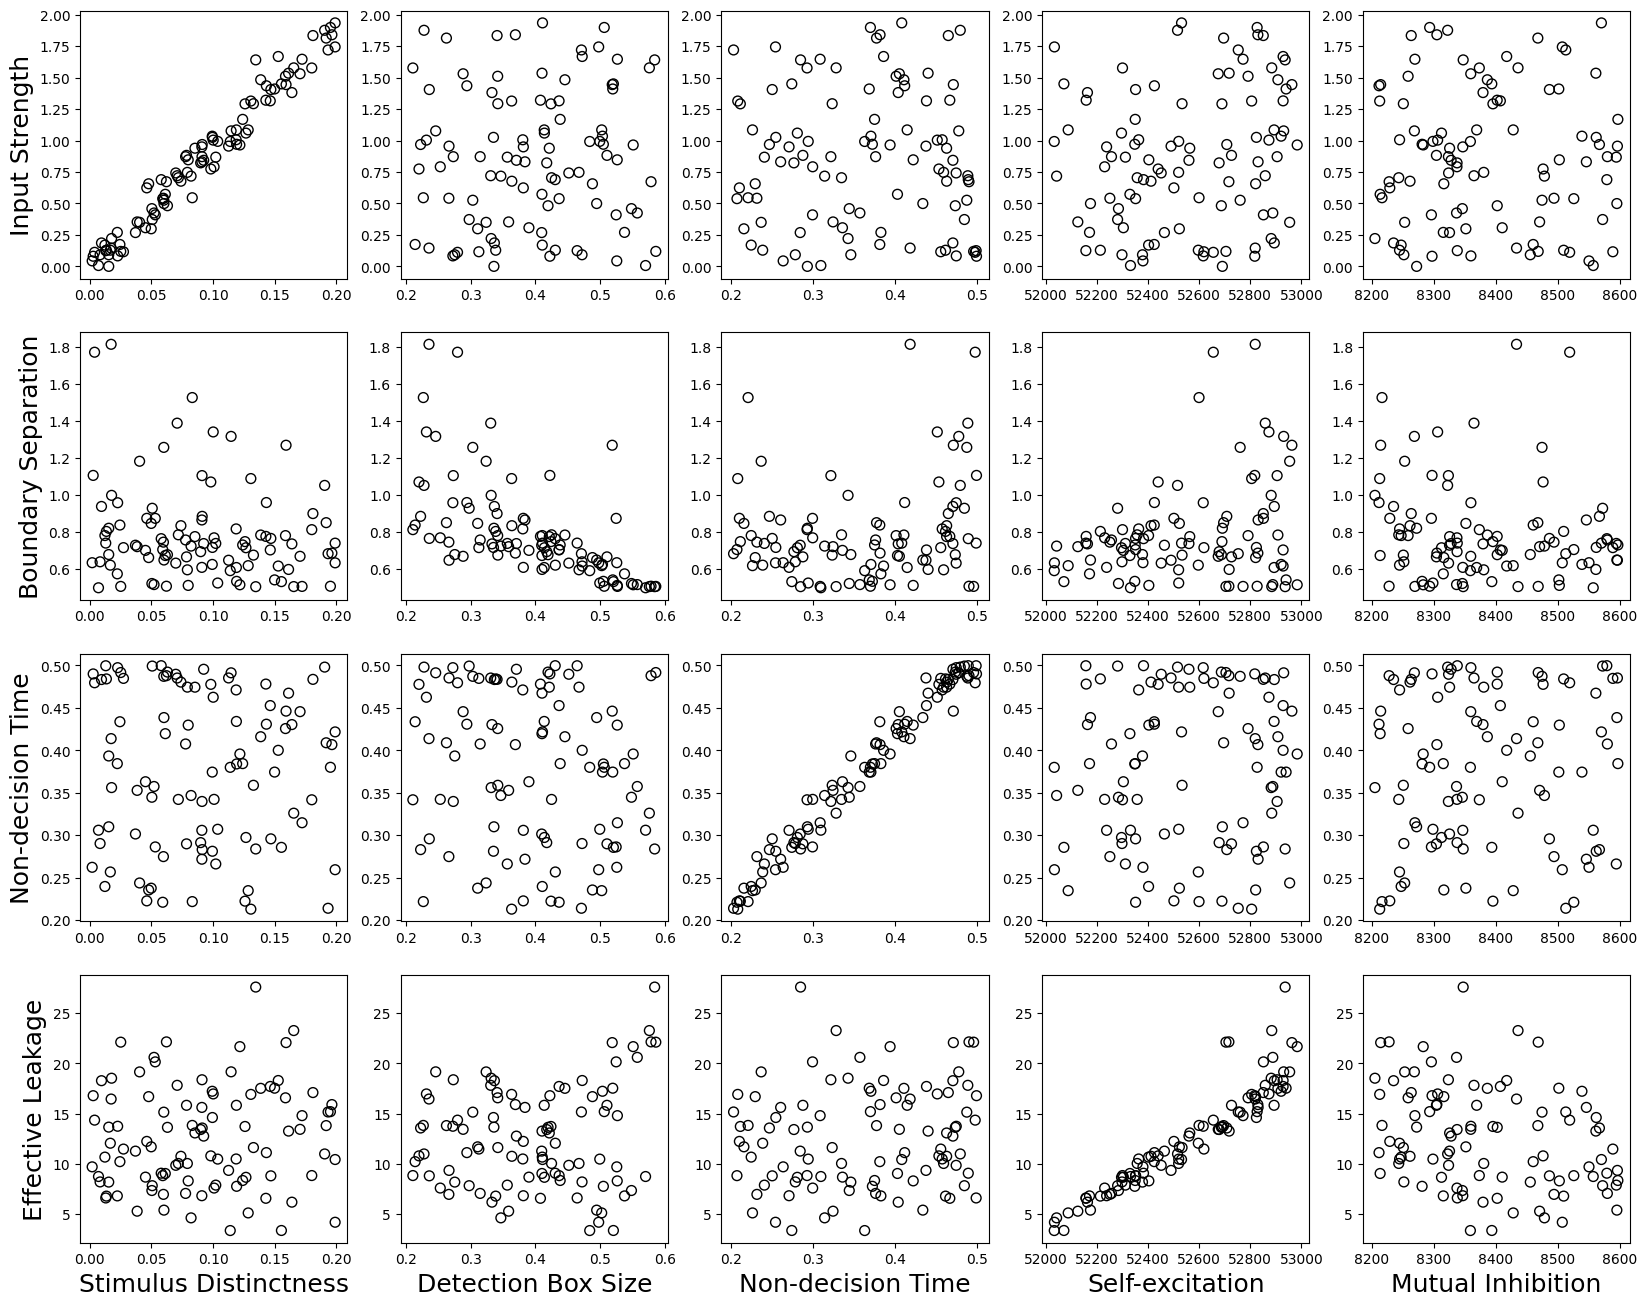

In [134]:
par_labels = ["Stimulus Distinctness", "Detection Box Size", "Non-decision Time","Self-excitation", "Mutual Inhibition"]
par_fitted_labels = ["Input Strength","Boundary Separation","Non-decision Time", "Effective Leakage"]
sim_fit_plot_all(param_IDM[:,:], par_fitted[:,:], par_labels, par_fitted_labels, 
                 s = 50, figsize=(20,16))

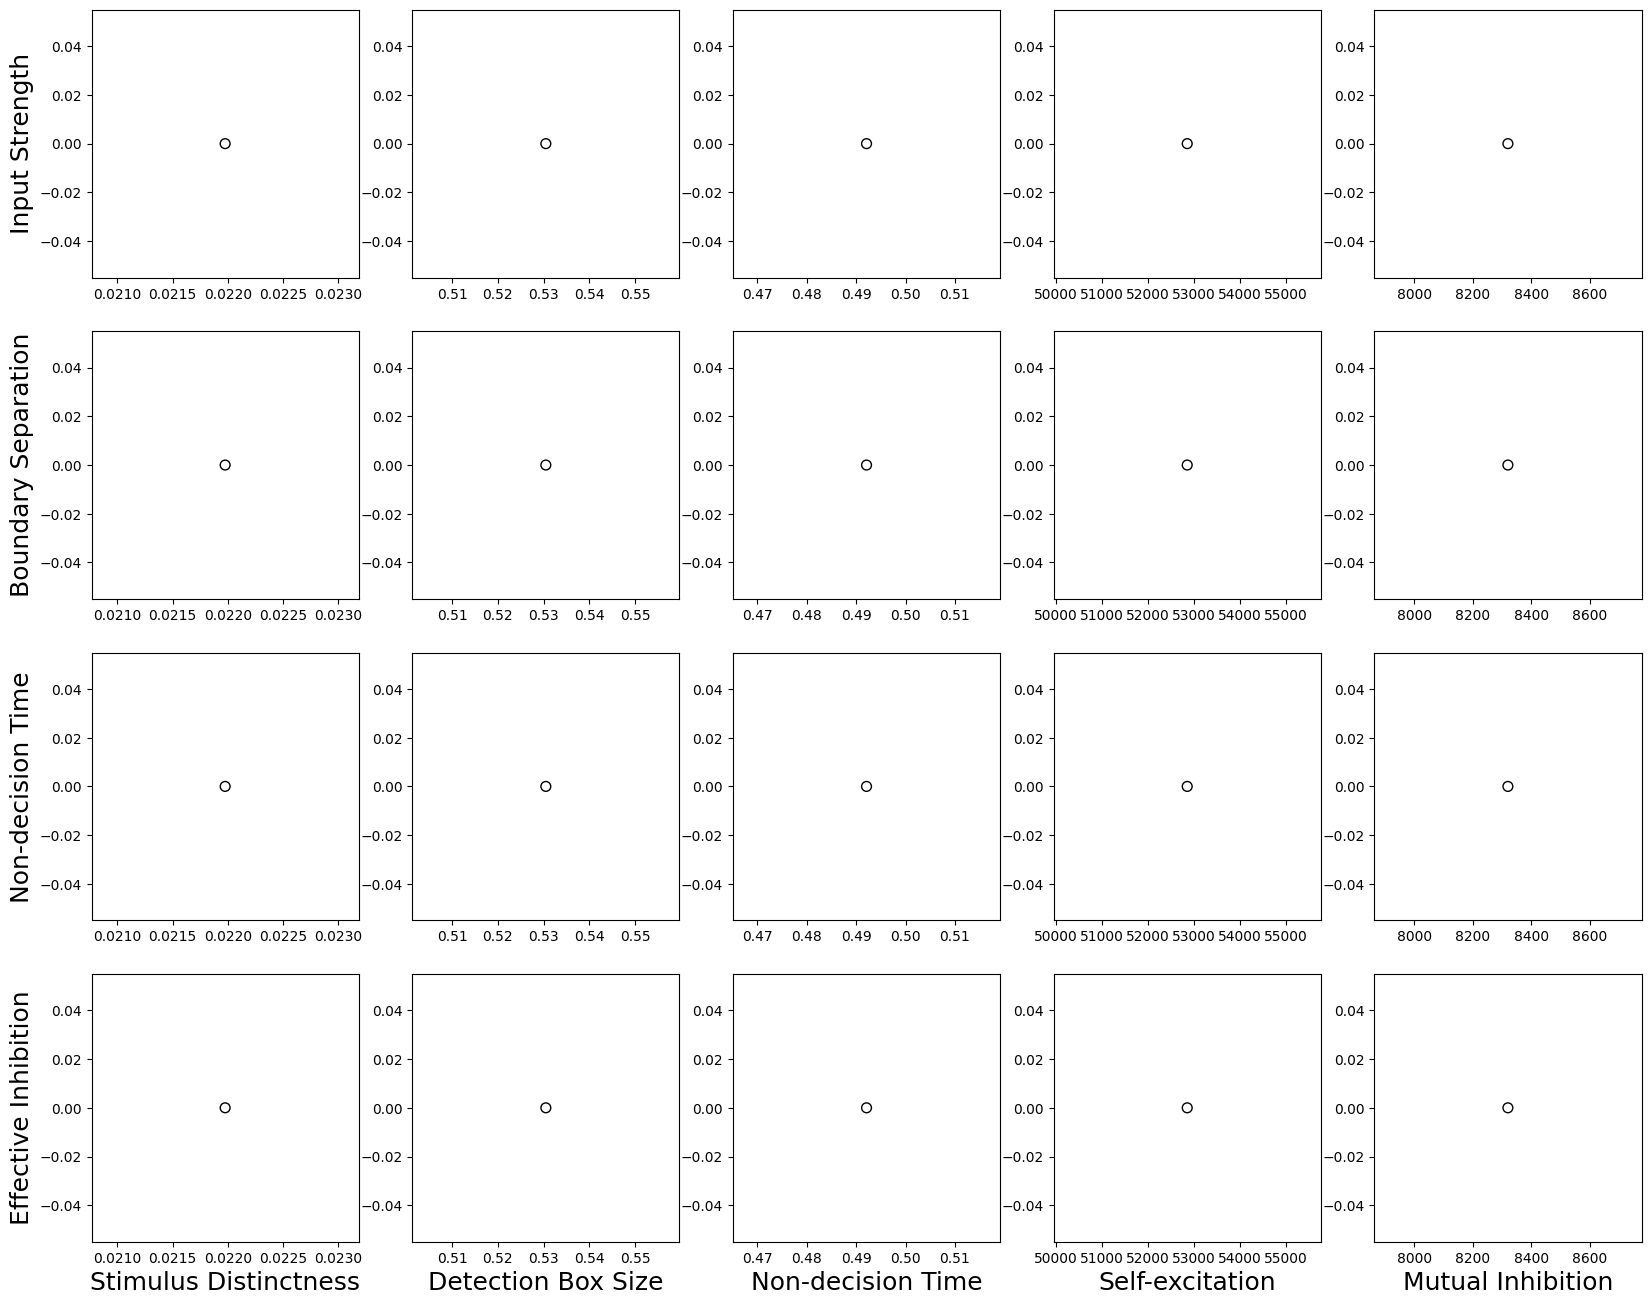

In [6]:
par_labels = ["Stimulus Distinctness", "Detection Box Size", "Non-decision Time","Self-excitation", "Mutual Inhibition"]
par_fitted_labels = ["Input Strength","Boundary Separation","Non-decision Time", "Effective Inhibition"]
sim_fit_plot_all(param_IDM[:,:], par_fitted[:,:], par_labels, par_fitted_labels, 
                 s = 50, figsize=(20,16))

In [120]:
par_fitted_copy = par_fitted.copy()
param_IDM_copy = np.array((param_IDM)).copy()